# Using the data to make predictions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as gg

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Create Database Connection

In [2]:
db = CurlingDB(db_name='world_curling_ss.db')

# Adding a more accurate hammer colour to the database
- The queries and commits to the database are currently commented out

## Get the hammer of each end

Methods to get the hammer
- If mens or womens teams then can try to grab the colour of the rock in the first frame
- If mixed doubles then can try to grab the majority from the first frame
- Else if no stone can be found in the first frame then backtrack one, then two ends to see if hammer can be determined by who scored most recently

### Get hammer info for a single game

In [3]:
# game = ('CU_WMCC2016P', 'SWE', 'JPN', 'Mens_Teams')
game = ('CUR_WWCC2017P', 'RUS', 'DEN', 'Womens_Teams')

In [4]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
"""
db.execute_query(hammer_query, game)
original_parsed_hammer_colour = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
original_parsed_hammer_colour

,end_id,end_num,db_hammer_colour,direction
0,148,1,yellow,down
1,149,2,yellow,up
2,150,3,yellow,up
3,151,4,red,down
4,152,5,yellow,up
5,153,6,red,up
6,154,7,yellow,down
7,155,8,red,down
8,156,9,yellow,down
9,157,10,yellow,up


In [5]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mens_Teams', 'Womens_Teams')
    AND
    p.frame_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
"""
db.execute_query(hammer_query2, game)
hammer_colour_prediction = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
hammer_colour_prediction

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,148,1,yellow,yellow,incon
1,149,2,yellow,yellow,incon
2,150,3,yellow,yellow,incon
3,151,4,red,red,red
4,152,5,yellow,yellow,yellow
5,153,6,yellow,yellow,yellow
6,154,7,red,red,red
7,155,8,yellow,yellow,yellow
8,156,9,yellow,yellow,yellow
9,157,10,red,red,red


In [6]:
hammer_colour_prediction.drop(columns=['frame_based', 'prev_based']).merge(original_parsed_hammer_colour.drop(columns=['end_num', 'direction']), on='end_id')

,end_id,end_num,pred_hammer_colour,db_hammer_colour
0,148,1,yellow,yellow
1,149,2,yellow,yellow
2,150,3,yellow,yellow
3,151,4,red,red
4,152,5,yellow,yellow
5,153,6,yellow,red
6,154,7,red,yellow
7,155,8,yellow,red
8,156,9,yellow,yellow
9,157,10,red,yellow


### Hammer info for all quads ends

In [7]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    m.type IN ('Mens_Teams', 'Womens_Teams')
"""
db.execute_query(hammer_query)
original_parsed_hammer_colour = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
original_parsed_hammer_colour

,end_id,end_num,db_hammer_colour,direction
0,1,1,red,down
1,2,2,yellow,up
2,3,3,red,up
3,4,4,yellow,down
4,5,5,yellow,up
...,...,...,...,...
11467,18178,6,yellow,up
11468,18179,7,red,down
11469,18180,8,red,down
11470,18181,9,red,down


In [8]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mens_Teams', 'Womens_Teams')
    AND
    p.frame_num = 1
"""
db.execute_query(hammer_query2)
hammer_colour_prediction = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
hammer_colour_prediction

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,1,1,incon,incon,incon
1,2,2,red,red,red
2,3,3,yellow,yellow,yellow
3,4,4,yellow,yellow,yellow
4,5,5,yellow,yellow,yellow
...,...,...,...,...,...
11467,18178,6,red,incon,red
11468,18179,7,yellow,incon,yellow
11469,18180,8,red,red,red
11470,18181,9,yellow,incon,yellow


### They agree on rougly 56% of ends, disagree on 42% and my new prediction has no idea for roughly 2%

In [9]:
all_colours = hammer_colour_prediction.drop(columns=['frame_based', 'prev_based']).merge(original_parsed_hammer_colour.drop(columns=['end_num', 'direction']), on='end_id')
pd.DataFrame({'counts': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts(), 'perc': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts() / all_colours.shape[0] * 100})

counts       perc
pred_hammer_colour db_hammer_colour                   
yellow             yellow              3259  28.408298
red                red                 3192  27.824268
yellow             red                 2442  21.286611
red                yellow              2378  20.728731
incon              yellow               104   0.906555
                   red                   97   0.845537

### Try the same thing for mixed doubles, individual game

In [10]:
game = ('CU_WMDCC2016P', 'NZL', 'CAN', 'Mixed_Doubles')

In [11]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
"""
db.execute_query(hammer_query, game)
original_parsed_hammer_colour = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
original_parsed_hammer_colour

,end_id,end_num,db_hammer_colour,direction
0,5053,1,red,down
1,5054,2,yellow,up
2,5055,3,yellow,up
3,5056,4,red,down
4,5057,5,yellow,up
5,5058,6,red,up
6,5059,7,red,down


In [12]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mixed_Doubles')
    AND
    p.frame_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
GROUP BY 1
"""
db.execute_query(hammer_query2, game)
hammer_colour_prediction = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
hammer_colour_prediction

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,5053,1,yellow,yellow,incon
1,5054,2,red,red,red
2,5055,3,yellow,yellow,yellow
3,5056,4,red,red,red
4,5057,5,yellow,yellow,yellow
5,5058,6,red,incon,red
6,5059,7,red,red,red


In [13]:
all_colours = hammer_colour_prediction.drop(columns=[]).merge(original_parsed_hammer_colour.drop(columns=['end_num', 'direction']), on='end_id')
all_colours

,end_id,end_num,pred_hammer_colour,frame_based,prev_based,db_hammer_colour
0,5053,1,yellow,yellow,incon,red
1,5054,2,red,red,red,yellow
2,5055,3,yellow,yellow,yellow,yellow
3,5056,4,red,red,red,red
4,5057,5,yellow,yellow,yellow,yellow
5,5058,6,red,incon,red,red
6,5059,7,red,red,red,red


In [14]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    m.type = 'Mixed_Doubles'
"""
db.execute_query(hammer_query)
original_parsed_hammer_colour = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
original_parsed_hammer_colour

,end_id,end_num,db_hammer_colour,direction
0,1790,1,yellow,down
1,1791,2,yellow,up
2,1792,3,red,up
3,1793,4,yellow,down
4,1794,5,red,up
...,...,...,...,...
5765,17834,3,yellow,up
5766,17835,4,yellow,down
5767,17836,5,yellow,up
5768,17837,6,red,up


In [15]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mixed_Doubles')
GROUP BY 1
"""
db.execute_query(hammer_query2)
hammer_colour_prediction = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
hammer_colour_prediction

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,1790,1,incon,incon,incon
1,1791,2,yellow,incon,yellow
2,1792,3,yellow,incon,yellow
3,1793,4,yellow,incon,yellow
4,1794,5,red,incon,red
...,...,...,...,...,...
5766,17834,3,yellow,incon,yellow
5767,17835,4,yellow,incon,yellow
5768,17836,5,yellow,incon,yellow
5769,17837,6,yellow,incon,yellow


### They agree on roughly 56% of ends, disagree on 30%, and new prediction is inconclusive on 13%

In [16]:
all_colours = hammer_colour_prediction.drop(columns=['frame_based', 'prev_based']).merge(original_parsed_hammer_colour.drop(columns=['end_num', 'direction']), on='end_id')
pd.DataFrame({'counts': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts(), 'perc': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts() / all_colours.shape[0] * 100})

counts       perc
pred_hammer_colour db_hammer_colour                   
red                red                 1666  28.873484
yellow             yellow              1601  27.746967
                   red                  883  15.303293
red                yellow               842  14.592721
incon              yellow               400   6.932409
                   red                  378   6.551127

### Make the prediction for all games to put into the database
- There may be a way to optimize the length of this command but I don't think it is necessary

- I tried the query below not checking previous ends all the way to checking three ends back.  Only checking for the stone in the first frame resulted in a 68% detection rate, checking back a single end yields a 95% detection rate and it seriously plateaus for checking two or three ends, doesn't pass 96%.

In [17]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        WHEN
            m.type = 'Mixed_Doubles'
        THEN
            CASE
                WHEN
                    COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
                THEN
                    'yellow'
                WHEN
                    COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
                THEN
                    'red'
                ELSE
                    CASE 
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            CASE
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    > 0
                                THEN
                                    'yellow'
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    < 0
                                THEN
                                    'red'
                                ELSE
                                    'incon'
                                END
                        END
                END
        WHEN
            m.type IN ('Mens_Teams', 'Womens_Teams', 'Mixed_Teams')
        THEN
            CASE
                s.colour
                WHEN
                    'red'
                THEN
                    'yellow'
                WHEN
                    'yellow'
                THEN
                    'red'
                ELSE
                    CASE 
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            CASE
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    > 0
                                THEN
                                    'yellow'
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    < 0
                                THEN
                                    'red'
                                ELSE
                                    'incon'
                                END
                        END
                END
        ELSE
            'incon'
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
GROUP BY 1
"""
db.execute_query(hammer_query2)
hammer_colour_prediction = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour'])
hammer_colour_prediction

,end_id,end_num,pred_hammer_colour
0,1,1,yellow
1,2,2,red
2,3,3,yellow
3,4,4,yellow
4,5,5,yellow
...,...,...,...
18177,18178,6,yellow
18178,18179,7,red
18179,18180,8,red
18180,18181,9,red


In [18]:
pd.DataFrame({'counts': hammer_colour_prediction[['pred_hammer_colour']].value_counts(), 'perc': hammer_colour_prediction[['pred_hammer_colour']].value_counts() / hammer_colour_prediction.shape[0] * 100})

,counts,perc
pred_hammer_colour,,
yellow,9445,51.946981
red,7959,43.774062
incon,778,4.278957


## Add new hammer colours to database

In [19]:
# Alter table command
add_hammer_pred = """
ALTER TABLE 
    End 
ADD 
    hammer_colour_alt TEXT
"""
# db.execute_query(add_hammer_pred)

## Populate field

In [20]:
add_hammer_pred_pop = """
UPDATE
    End
SET
    hammer_colour_alt = ?
WHERE
    end_id = ?
"""

In [21]:
populate_values = [(x[1], x[0]) for x in hammer_colour_prediction.drop(columns='end_num').query('pred_hammer_colour != "incon"').itertuples(index=False, name=None)]
populate_values[:5]

[('yellow', 1), ('red', 2), ('yellow', 3), ('yellow', 4), ('yellow', 5)]

In [22]:
# db.execute_many(add_hammer_pred_pop, populate_values)

# Exploration

## Predicting winner from ratings of players

### Get the data

In [23]:
# Get the list of players from a team from a match
players_query = """
SELECT
    DISTINCT 
    m.match_id,
    p.name,
    p.team,
    CASE
        WHEN
            SUBSTR(p.team, 1, 3) = SUBSTR(m.team_1, 1, 3)
        THEN
            'team1'
        WHEN
            SUBSTR(p.team, 1, 3) = SUBSTR(m.team_2, 1, 3)
        THEN
            'team2'
        END

FROM 
    Player p
JOIN
    Throw t
ON
    p.player_id = t.player_id
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mens_Teams', 'Womens_Teams', 'Mixed_Teams')
"""
db.execute_command(players_query)
game_players = pd.DataFrame(db.cursor.fetchall(), columns=['match_id', 'player', 'team', 'rel_team'])
game_players

,match_id,player,team,rel_team
0,1,FREDERICKS ARMSTR.,AUS,team2
1,1,THOMPSON H,NZL,team1
2,1,POWELL A,AUS,team2
3,1,JEYARANJAN T,NZL,team1
4,1,FORGE K,AUS,team2
...,...,...,...,...
11234,2165,DUFF H,SCO,team2
11235,2165,KIM H,KOR,team1
11236,2165,MACDONALD A,SCO,team2
11237,2165,KIM M,KOR,team1


In [24]:
# Get the ratings of all players
rating_query = """
SELECT
    p.name,
    p.team,
    COUNT(*),
    AVG(t.rating)
FROM 
    Player p
JOIN
    Throw t
ON
    p.player_id = t.player_id
JOIN
    End e
ON
    t.end_id = e.end_id
/*WHERE 
    p.name IN 
        (SELECT
            DISTINCT 
            p.name
        FROM 
            Player p
        JOIN
            Throw t
        ON
            p.player_id = t.player_id
        JOIN
            End e
        ON
            t.end_id = e.end_id
        JOIN
            Match m
        ON
            e.match_id = m.match_id
        JOIN
            Event e2
        ON
            m.event_id = e2.event_id
        WHERE m.match_id = 1)*/
GROUP BY
    1

"""
db.execute_command(rating_query)
player_ratings = pd.DataFrame(db.cursor.fetchall(), columns=['player', 'team', 'throw_count', 'mean_rating'])
player_ratings

,player,team,throw_count,mean_rating
0,110.3cm,Shoot-out,1,NaN
1,15.3cm,Shoot-out,1,NaN
2,17.1cm,Shoot-out,1,NaN
3,17.7cm,Shoot-out,1,NaN
4,199.6cm,Shoot-out,5,NaN
...,...,...,...,...
936,ZHOU Y,CHN,516,3.131783
937,ZHUZBAY A,KAZ,475,2.686316
938,ZIOLO T,POL,14,2.000000
939,ZOU D,CHN,431,3.000000


In [25]:
# Get the winning team for all matches
winner_query = """
SELECT
    m.match_id,
    CASE
        WHEN
            m.team_1_final_score > m.team_2_final_score
        THEN
            'team1'
        WHEN
            m.team_1_final_score < m.team_2_final_score
        THEN
            'team2'
        ELSE
            'draw'
        END
FROM 
    Match m
"""
db.execute_command(winner_query)
winner_list = pd.DataFrame(db.cursor.fetchall(), columns=['match_id', 'winner']).query('winner != "draw"')
winner_list.set_index('match_id')

,winner
match_id,
1,team1
2,team2
3,team1
4,team2
5,team1
...,...
2161,team1
2162,team2
2163,team2


#### Combine the players from the games with their ratings

In [26]:
# Find all matches with 8 players listed
complete_matches = game_players.groupby('match_id')['player'].count().where(lambda x: x == 8).dropna().index.values
# Filter the matches and players by the above list
game_players = game_players[game_players.match_id.isin(complete_matches)].reset_index(drop=True)
# Combine the players with their ratings
game_players = game_players.merge(player_ratings, how='left')
# Identify the player/team of the player and add column
game_players = game_players.sort_values(['match_id', 'rel_team', 'mean_rating']).reset_index(drop=True)
game_players['player_iden'] = game_players.apply(lambda x: f"player_{x.name % 8}", axis=1)
#.reset_index(drop=True).reset_index().apply(lambda x: f"player_{x['index'] % 8}", axis=1)
game_players.head()

,match_id,player,team,rel_team,throw_count,mean_rating,player_iden
0,1,THOMPSON H,NZL,team1,40.0,1.950000,player_0
1,1,BECKER B,NZL,team1,417.0,2.429257,player_1
2,1,JEYARANJAN T,NZL,team1,58.0,2.534483,player_2
3,1,SMITH J,NZL,team1,58.0,2.706897,player_3
4,1,WILLIAMS H,AUS,team2,40.0,1.950000,player_4


#### Reformat as features, 0-3 are team1, 4-7 are team2

In [27]:
data = game_players.pivot_table(index='match_id', columns='player_iden', values='mean_rating').dropna()
data = data.merge(winner_list, left_index=True, right_index=True)
data

,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,match_id,winner
1,1.950000,2.429257,2.534483,2.706897,1.950000,2.150000,2.350000,2.500000,2,team2
2,2.434312,2.523044,2.569444,3.234043,2.499278,2.618915,3.138889,3.231293,3,team1
3,2.738854,2.750000,2.800786,2.850829,2.445545,2.668142,3.057851,3.363248,4,team2
4,2.809697,2.964628,2.979339,3.019022,3.051587,3.063518,3.117188,3.285714,5,team1
5,2.878205,2.891026,2.931667,3.166209,2.963874,3.122929,3.194154,3.250522,6,team1
...,...,...,...,...,...,...,...,...,...,...
2160,2.616379,2.657407,2.904762,2.981481,2.987342,3.035461,3.121875,3.250000,2161,team1
2161,2.987342,3.035461,3.121875,3.250000,2.895833,2.978947,3.020833,3.083333,2162,team2
2162,2.626263,2.745283,3.219388,3.383333,2.895833,2.978947,3.020833,3.083333,2163,team2
2163,2.895833,2.978947,3.020833,3.083333,2.788462,2.815789,3.000000,3.166667,2164,team1


### Create train/test split

In [28]:
from sklearn.model_selection import train_test_split

features = [f"player_{x}" for x in range(8)]
target = 'winner'

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], train_size=0.8)

### PCA
- There is some room to remove features but 8 features isn't too many so we'll stick with it

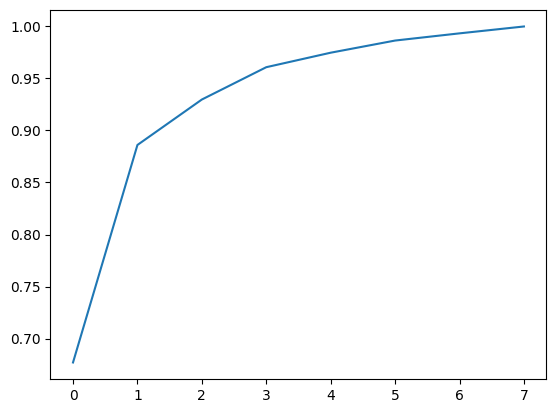

In [29]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

### Isometric Mapping

(904, 3)


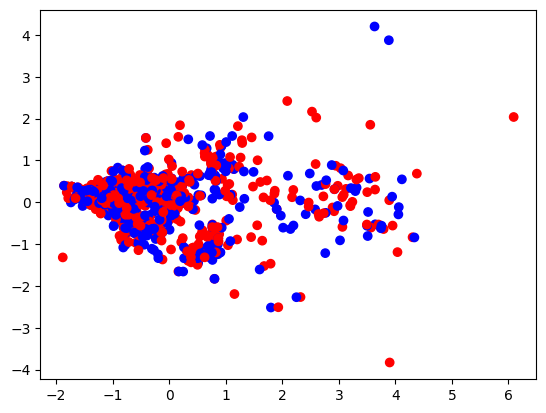

In [30]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=3)
iso_map = iso.fit_transform(X_train)
print(iso_map.shape)
plt.scatter(iso_map[:, 0], iso_map[:, 1], c=y_train.apply(lambda x: 'red' if x == 'team1' else 'blue'))

### Test a number of models and an ensemble
- They are barely better than chance

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

models = {'SVC': SVC(kernel='rbf'),
          'SVC - Linear': SVC(kernel='linear'),
          'Random Forest': RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=7),
          'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression()),
          'SGD Classifier': SGDClassifier(),
          'K Neighbours Classifier': KNeighborsClassifier(n_neighbors=4)
         }

pred = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred[name] = model.predict(X_test)
    print(f"Accuracy: {sum((pred[name] == y_test)) / len(pred[name]):.5f}, Model: {name}")

ensemble_pred = pd.DataFrame(pred).T.applymap(lambda x: x[-1]).median().apply(lambda x: 1 if x == 1 else 2).to_numpy()
print(f"Accuracy: {sum((ensemble_pred == y_test.apply(lambda x: int(x[-1])).to_numpy())) / len(ensemble_pred):.5f}, Model: Ensemble")

Accuracy: 0.47577, Model: SVC
Accuracy: 0.48458, Model: SVC - Linear
Accuracy: 0.48899, Model: Random Forest
Accuracy: 0.51542, Model: Logistic Regression
Accuracy: 0.51982, Model: SGD Classifier
Accuracy: 0.49339, Model: K Neighbours Classifier
Accuracy: 0.49339, Model: Ensemble


# Predicting winner from who has the hammer

### Get the data

In [32]:
sql = """
SELECT
    m.match_id,
    e.num,
    e.hammer_colour_alt,
    CASE
        WHEN
            m.team_1_final_score > m.team_2_final_score
        THEN
            'red'
        WHEN
            m.team_1_final_score < m.team_2_final_score
        THEN
            'yellow'
        ELSE
            'draw'
        END

FROM 
    End e
JOIN
    Match m
ON
    e.match_id = m.match_id
WHERE
    m.type IN ('Mens_Teams', 'Womens_Teams')
"""
db.execute_query(sql)
hammer_results = pd.DataFrame(db.cursor.fetchall(), columns=['match_id', 'end_num', 'hammer_colour', 'win_colour'])
# hammer_results['hammer_won'] = (hammer_results.hammer_colour == hammer_results.win_colour)
# hammer_results = hammer_results.groupby(['end_num', 'hammer_won'])['win_colour'].count().reset_index()
hammer_results = hammer_results.drop(columns=['win_colour']).pivot(index='match_id', columns='end_num')
hammer_results.columns = [f"end_{x[1]}" for x in hammer_results.columns]
hammer_results = hammer_results.reset_index()
hammer_results = hammer_results.applymap(lambda x: 1 if x == 'red' else 0 if x == 'yellow' else x)
hammer_results

,match_id,end_1,end_2,end_3,end_4,end_5,end_6,end_7,end_8,end_9,end_10,end_11
0,1,0,1,0,0,0,0.0,0.0,0.0,1.0,1.0,NaN
1,2,1,0,1,0,0,1.0,0.0,1.0,1.0,1.0,NaN
2,3,0,0,1,0,0,0.0,1.0,1.0,NaN,NaN,NaN
3,4,0,0,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN
4,5,1,0,1,0,0,0.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2161,1,1,0,0,0,1.0,1.0,0.0,0.0,1.0,NaN
1265,2162,0,0,0,0,1,0.0,1.0,0.0,1.0,1.0,NaN
1266,2163,0,1,0,1,0,0.0,0.0,0.0,0.0,NaN,NaN
1267,2164,0,0,1,0,1,0.0,1.0,0.0,0.0,1.0,NaN


In [33]:
winner_list['win_colour'] = winner_list.winner.apply(lambda x: 'red' if x == 'team1' else 'yellow')
hammer_results = hammer_results.merge(winner_list.drop(columns='winner'), on='match_id')
hammer_results

,match_id,end_1,end_2,end_3,end_4,end_5,end_6,end_7,end_8,end_9,end_10,end_11,win_colour
0,1,0,1,0,0,0,0.0,0.0,0.0,1.0,1.0,NaN,red
1,2,1,0,1,0,0,1.0,0.0,1.0,1.0,1.0,NaN,yellow
2,3,0,0,1,0,0,0.0,1.0,1.0,NaN,NaN,NaN,red
3,4,0,0,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,yellow
4,5,1,0,1,0,0,0.0,1.0,NaN,NaN,NaN,NaN,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,2161,1,1,0,0,0,1.0,1.0,0.0,0.0,1.0,NaN,red
1264,2162,0,0,0,0,1,0.0,1.0,0.0,1.0,1.0,NaN,yellow
1265,2163,0,1,0,1,0,0.0,0.0,0.0,0.0,NaN,NaN,yellow
1266,2164,0,0,1,0,1,0.0,1.0,0.0,0.0,1.0,NaN,red


In [34]:
end_num = 2
features = [f"end_{x}" for x in range(1, end_num)]
target = 'win_colour'
hammer_results_trim = hammer_results[[*features, target, 'match_id']].dropna()
X_train, X_test, y_train, y_test = train_test_split(hammer_results_trim[features], hammer_results_trim[target], test_size=0.2)
print(X_train.shape)
X_train.head()

(1014, 1)


,end_1
377,0
910,1
268,0
1040,1
98,1


### PCA

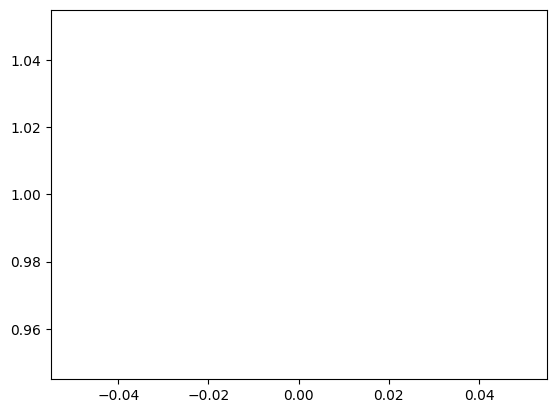

In [35]:
from sklearn.decomposition import PCA
num_components = 8
end_pca = PCA()
end_pca.fit(X_train, y_train)
plt.plot(np.cumsum(end_pca.explained_variance_ratio_))
# Clearly very little redundance here

### Test a number of models and an ensemble

In [36]:
models = {'SVC':                            SVC(kernel='rbf'),
          'SVC - Linear':                   SVC(kernel='linear'),
          'Random Forest':                  RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=9),
          'Logistic Regression':            LogisticRegression(),
          'Logistic Regression - Scaled':   make_pipeline(StandardScaler(), LogisticRegression()),
          'SGD Classifier':                 SGDClassifier(),
          'K Neighbours Classifier':        KNeighborsClassifier(n_neighbors=4)
         }


pred = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred[name] = model.predict(X_test)
    print(f"Accuracy: {sum((pred[name] == y_test)) / len(pred[name]):0.5f}, Model: {name}")

# Ensemble evaluation
ensemble_pred = pd.DataFrame(pred).mode(axis=1)
print(f"Accuracy: {sum((ensemble_pred.iloc[:, 0].to_numpy() == y_test.to_numpy())) / len(ensemble_pred):0.5f}, Model: Ensemble")


Accuracy: 0.57087, Model: SVC
Accuracy: 0.57087, Model: SVC - Linear
Accuracy: 0.57087, Model: Random Forest
Accuracy: 0.57087, Model: Logistic Regression
Accuracy: 0.57087, Model: Logistic Regression - Scaled
Accuracy: 0.57087, Model: SGD Classifier
Accuracy: 0.52756, Model: K Neighbours Classifier
Accuracy: 0.57087, Model: Ensemble


# Predicting winner from Player Rating and Hammer Colour

### Getting Data

In [37]:
full_data = hammer_results_trim.merge(data, on='match_id').drop(columns=['winner', 'match_id'])
full_data

,end_1,win_colour,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7
0,1,yellow,1.950000,2.429257,2.534483,2.706897,1.950000,2.150000,2.350000,2.500000
1,0,red,2.434312,2.523044,2.569444,3.234043,2.499278,2.618915,3.138889,3.231293
2,0,yellow,2.738854,2.750000,2.800786,2.850829,2.445545,2.668142,3.057851,3.363248
3,1,red,2.809697,2.964628,2.979339,3.019022,3.051587,3.063518,3.117188,3.285714
4,0,red,2.878205,2.891026,2.931667,3.166209,2.963874,3.122929,3.194154,3.250522
...,...,...,...,...,...,...,...,...,...,...
997,1,red,2.616379,2.657407,2.904762,2.981481,2.987342,3.035461,3.121875,3.250000
998,0,yellow,2.987342,3.035461,3.121875,3.250000,2.895833,2.978947,3.020833,3.083333
999,0,yellow,2.626263,2.745283,3.219388,3.383333,2.895833,2.978947,3.020833,3.083333
1000,0,red,2.895833,2.978947,3.020833,3.083333,2.788462,2.815789,3.000000,3.166667


In [38]:
X_train, X_test, y_train, y_test = train_test_split(full_data.drop(columns=['win_colour']), full_data['win_colour'], test_size=0.2)
print(X_train.shape)
X_train.head()

(801, 9)


,end_1,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7
574,1,2.742710,2.867438,2.945860,3.109261,3.102740,3.163231,3.172936,3.333586
482,1,2.916429,2.920844,3.088235,3.413934,2.645314,3.109589,3.215909,3.463636
410,1,3.135338,3.309251,3.338443,3.348665,2.931434,3.089206,3.166964,3.351896
627,1,2.703488,2.977612,3.160920,3.253731,2.717593,2.819932,2.824477,3.137728
927,0,2.925926,3.000000,3.074074,3.203704,2.689076,3.117801,3.145119,3.289817


### Models

In [39]:
models = {'SVC':                            SVC(kernel='rbf'),
          'SVC - Linear':                   SVC(kernel='linear'),
          'Random Forest':                  RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=9),
          'Logistic Regression':            LogisticRegression(),
          'Logistic Regression - Scaled':   make_pipeline(StandardScaler(), LogisticRegression()),
          'SGD Classifier':                 SGDClassifier(),
          'K Neighbours Classifier':        KNeighborsClassifier(n_neighbors=4)
         }


pred = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred[name] = model.predict(X_test)
    print(f"Accuracy: {sum((pred[name] == y_test)) / len(pred[name]):0.5f}, Model: {name}")

# Ensemble evaluation
ensemble_pred = pd.DataFrame(pred).mode(axis=1)
print(f"Accuracy: {sum((ensemble_pred.iloc[:, 0].to_numpy() == y_test.to_numpy())) / len(ensemble_pred):0.5f}, Model: Ensemble")


Accuracy: 0.52736, Model: SVC
Accuracy: 0.52239, Model: SVC - Linear
Accuracy: 0.52239, Model: Random Forest
Accuracy: 0.52736, Model: Logistic Regression
Accuracy: 0.53234, Model: Logistic Regression - Scaled
Accuracy: 0.52239, Model: SGD Classifier
Accuracy: 0.47761, Model: K Neighbours Classifier
Accuracy: 0.52736, Model: Ensemble


# PyTorch

## Imports

In [40]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from tqdm import tqdm

device = 'mps' if torch.has_mps else 'cpu'
print(device)

mps


## Create Dataset

In [41]:
# Clean some data
torch_data = full_data.copy(deep=True)
torch_data['win_colour'] = torch_data.win_colour.apply(lambda x: 1 if x == 'red' else (0 if 'yellow' else x)).astype('float32')
for x in torch_data.columns:
    torch_data[x] = torch_data[x].astype('float32')
torch_data['team1rating'] = torch_data[[f'player_{x}' for x in range(4)]].sum(axis=1)
torch_data['team2rating'] = torch_data[[f'player_{x}' for x in range(4, 8)]].sum(axis=1)
torch_features = torch.from_numpy(torch_data.drop(columns=['win_colour']).values)
torch_labels = torch.from_numpy(torch_data.win_colour.values)
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(torch_features, torch_labels, test_size=0.2)

In [42]:
# Create datasets from tensors
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

In [43]:
# Create dataloaders from datasets
batch_size = 32
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size)
test_dl = DataLoader(dataset=test_ds, batch_size=batch_size)

## Build model

In [44]:
class Classifier_Network(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim) -> None:
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.linear_relu_stack(x)

## Train and Test Loop

In [45]:
def train(model, dataloader, loss_fn, optimizer):
    # Set model to train mode, affects certain layers that have training specific modes like batching and norming, not actually required for the current model
    model.train()
    correct = 0
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Use the model to generate a prediction with current values
        pred = model(X)
        # Calculate the loss using the given loss function
        loss = loss_fn(pred, torch.unsqueeze(y, 1))
        # Zero out the gradients of the parameters of the model(to avoid previous rounds affecting this one)
        optimizer.zero_grad()
        # Backwards propagation calculate the gradients for each parameter
        loss.backward()
        # Apply the gradients to each model parameter using the optimizer
        optimizer.step()

        # Count the number of correct predictions
        correct += sum(abs(pred - torch.unsqueeze(y, 1)) < 0.5)

    return (loss.item(), (correct.detach().cpu().numpy()/len(dataloader.dataset))[0])

In [46]:
def test(model, dataloader, loss_fn):
    # Set model to eval mode, disables/modifies some layers
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Use the model to generate a prediction
            pred = model(X)
            # Calculate the loss
            loss = loss_fn(pred, torch.unsqueeze(y, 1)).item()

            # Count the number of correct predictions
            correct += sum(abs(pred - torch.unsqueeze(y, 1)) < 0.5)
        
    return (loss, (correct.detach().cpu().numpy()/len(dataloader.dataset))[0])

## Model Fitting and Testing

In [47]:
model = Classifier_Network(11, 20, 1).to(device)
optimizer = torch.optim.Adadelta(model.parameters())
loss_fn = nn.BCELoss()
train_loss_hist = []
test_loss_hist = []
train_accuracy_hist = []
test_accuracy_hist = []

100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


(0.6347985863685608, 0.5174129353233831)


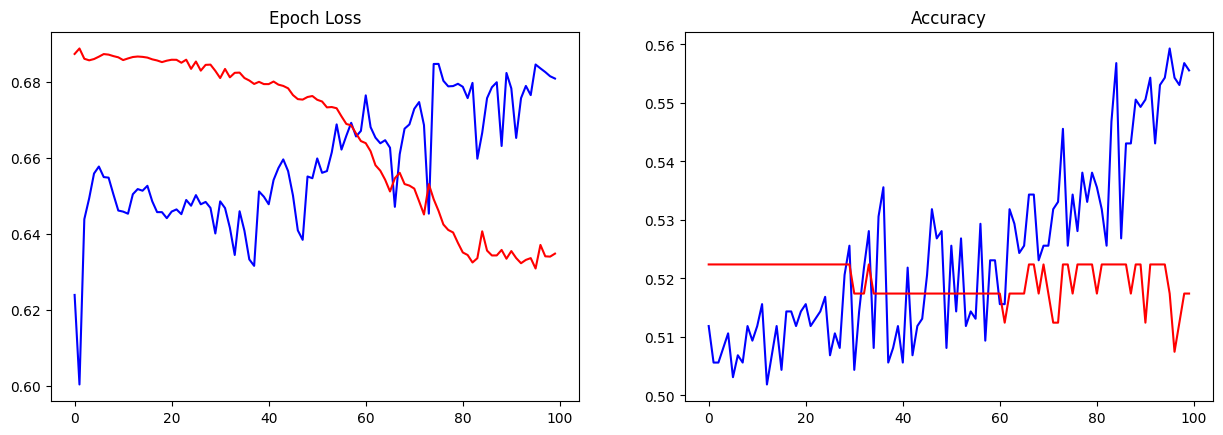

In [48]:
num_epochs = 100
testing = []
for i in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(model, train_dl, loss_fn, optimizer)
    test_loss, test_accuracy = test(model, test_dl, loss_fn)
    train_loss_hist.append(train_loss)
    train_accuracy_hist.append(train_accuracy)
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(test_accuracy)

print(test(model, test_dl, loss_fn))

fig, ax = plt.subplots(1, 2)
ax[0].plot(train_loss_hist, c='blue')
ax[0].plot(test_loss_hist, c='red')
ax[0].set_title('Epoch Loss')
ax[1].plot(train_accuracy_hist, c='blue')
ax[1].plot(test_accuracy_hist, c='red')
ax[1].set_title('Accuracy')
# red is the test accuracy
fig.set_figwidth(15)